In [36]:
# Import libraries
from numpy.random import seed

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
from pathlib import Path, PurePath
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

In [3]:
DATA_PATH=PurePath('./data/')
INPUT_PATH=PurePath(DATA_PATH,'input')
INPUT_TRAIN_PATH=PurePath(INPUT_PATH,'train')
INPUT_TEST_PATH=PurePath(INPUT_PATH,'test')
IMAGE_SIZE=96

In [4]:
# 
print(os.getcwd())
print(os.listdir())

C:\cygwin64\home\salis\git\repos\DSC680\breast-cancer
['.ipynb_checkpoints', 'breast-cancer-eda-Copy1.ipynb', 'breast-cancer-eda.ipynb', 'data']


In [5]:
print(os.listdir(DATA_PATH))

['input', 'test.zip', 'train', 'train.zip', 'train_labels.csv', 'train_labels.csv.zip', 'validation']


In [6]:
# how many images?
print(len(os.listdir(INPUT_TRAIN_PATH)))
print(len(os.listdir(INPUT_TEST_PATH)))

220028
57458


In [7]:
# load the training labels
data_df = pd.read_csv(f'{DATA_PATH}/train_labels.csv')

In [8]:
data_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


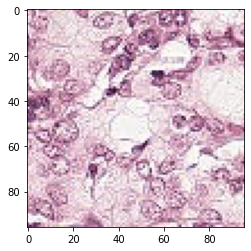

In [9]:
# from research, these two images are noted as causing issues
# dd6dfed324f9fcb6f93f46f32fc800f2ec196be2
# 9369c7278ec8bcc6c880d99194de09fc2bd4efbe
img = mpimg.imread(f'{INPUT_TRAIN_PATH}/dd6dfed324f9fcb6f93f46f32fc800f2ec196be2.tif')
imgplot = plt.imshow(img)

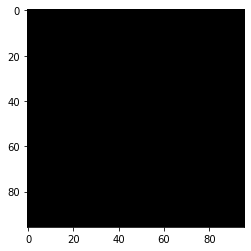

In [10]:
img = mpimg.imread(f'{INPUT_TRAIN_PATH}/9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif')
imgplot = plt.imshow(img)

In [12]:
# remove images noted above
data_df = data_df[data_df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
data_df = data_df[data_df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

In [13]:
print(data_df.shape)

(220023, 2)


In [14]:
data_df['label'].value_counts()

0    130907
1     89116
Name: label, dtype: int64

In [15]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=PurePath(IMAGE_PATH,sample.iloc[j]['id']).__str__() + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

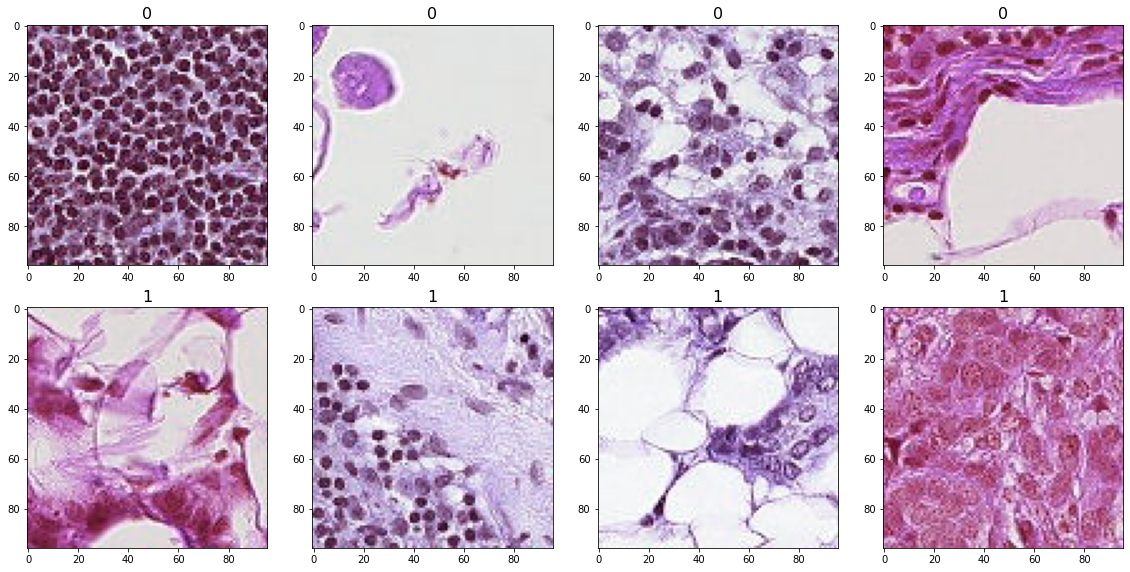

In [16]:
draw_category_images('label',4, data_df, INPUT_TRAIN_PATH)

In [17]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

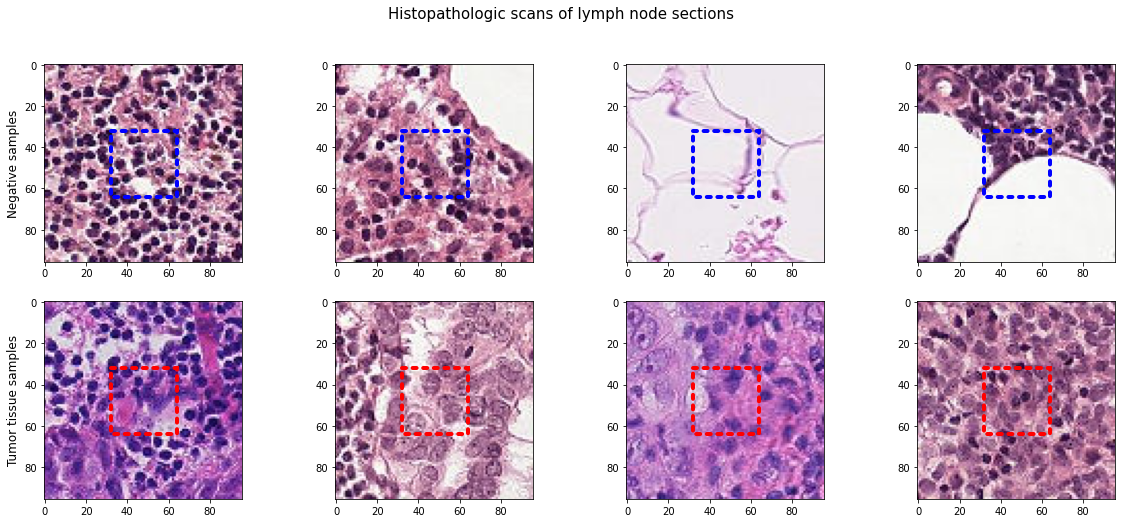

In [18]:
# random sampling
shuffled = shuffle(data_df)

fig, ax = plt.subplots(2,4, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=15)

# Negatives
for i, idx in enumerate(shuffled[shuffled['label'] == 0]['id'][:4]):
    path = PurePath(INPUT_TRAIN_PATH,idx).__str__()
    ax[0,i].imshow(readImage(path + '.tif'))
    
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
    
ax[0,0].set_ylabel('Negative samples', size='large')

# Positives
for i, idx in enumerate(shuffled[shuffled['label'] == 1]['id'][:4]):
    path = PurePath(INPUT_TRAIN_PATH,idx).__str__()
    ax[1,i].imshow(readImage(path + '.tif'))
    
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
    
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

In [19]:
# set some variables
SEED=101
SAMPLE_SIZE=75000
TEST_SIZE=0.15

In [20]:
# create sets
neg_df=data_df[data_df['label']==0].sample(SAMPLE_SIZE,random_state=SEED)
pos_df=data_df[data_df['label']==1].sample(SAMPLE_SIZE,random_state=SEED)

# concat dataframes
data_df = pd.concat([neg_df, pos_df], axis=0).reset_index(drop=True)

# shuffle the data
data_df = shuffle(data_df)

data_df['label'].value_counts()

1    75000
0    75000
Name: label, dtype: int64

In [21]:
# do a train/test split
train_df, validation_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=SEED, stratify=data_df['label'])

In [22]:
print(train_df.shape)
print(validation_df.shape)

(127500, 2)
(22500, 2)


In [23]:
# create directories to organize train/validation
parent_paths = ['train','validation']

for folder in parent_paths:
    parent = PurePath(DATA_PATH,folder)
    for subfolder in ["0","1"]:
        new_path = PurePath(parent,subfolder)
        Path(new_path).mkdir(parents=True, exist_ok=True)

In [25]:
TRAIN_PATH=PurePath(DATA_PATH,'train')
VALIDATION_PATH=PurePath(DATA_PATH,'validation')

## The following cells copies images, previously ran so changed cell-type

In [26]:
IMAGE_SIZE = 96
num_train_samples = len(train_df)
num_val_samples = len(validation_df)
train_batch_size = 32
val_batch_size = 32

# Create data generators
datagen  = ImageDataGenerator(rescale=1.0/255.0,
                                  vertical_flip = True,
                                  horizontal_flip = True)

# we won't do augmentation on validation data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = test_datagen.flow_from_directory(VALIDATION_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = test_datagen.flow_from_directory(VALIDATION_PATH,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

train_steps=train_gen.n//train_gen.batch_size
val_steps=val_gen.n//val_gen.batch_size
#STEP_SIZE_TEST=test_gen.n//test_gen.batch_size

Found 127500 images belonging to 2 classes.
Found 22500 images belonging to 2 classes.
Found 22500 images belonging to 2 classes.


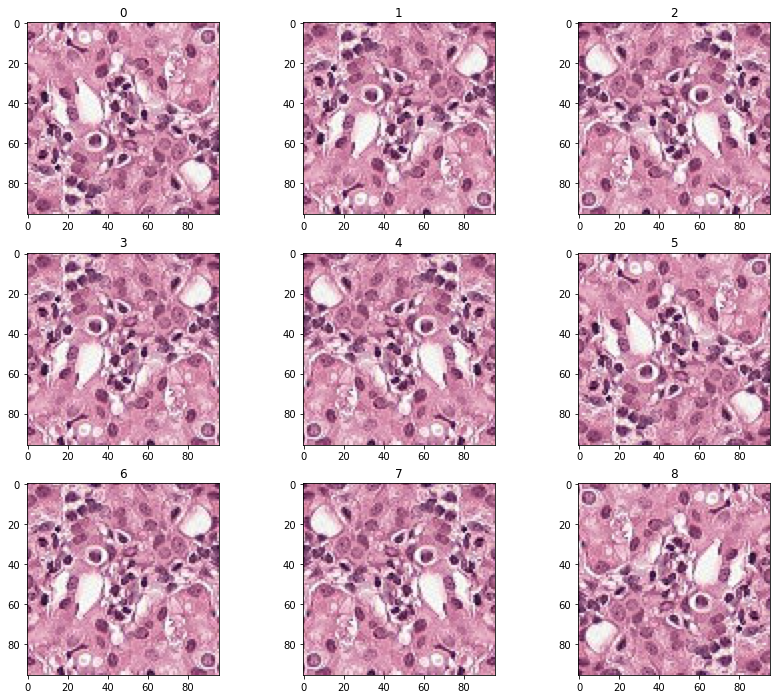

In [29]:
# Example of image generation
count = 8

# grab an image and conver it to an np array
imgs = os.listdir(INPUT_TRAIN_PATH)[:1]
image = img_to_array(load_img(f'{INPUT_TRAIN_PATH}/'+imgs[0]))
image = image.reshape((1,) + image.shape)

# set up some plot stuff
fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust()

# Create a flow of images based on my image
images_flow = datagen.flow(image, batch_size=1)

# loop through image flow
for i, new_images in enumerate(images_flow):
    
    # Grab just the first, since batch size is 1
    new_image = array_to_img(new_images[0], scale=True)
    
    # add a subplot, and add image
    ax = fig.add_subplot(3,3, i + 1)
    ax.imshow(new_image)
    ax.set_title(i)

    # break when our counter is reached
    if i >= count:
        break

In [30]:
# Create model
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

In [ ]:
model.compile(Adam(lr=0.001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [38]:
kernel_size = (3,3)
pool_size= (2,2)

#base_filters = 16
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
# (CONV => RELU => POOL) * 2
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# (CONV => RELU => POOL) * 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# (CONV => RELU => POOL) * 2
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# sigmoid classifier
model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_7 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 44, 44, 64)       

In [39]:
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

In [32]:
## FIRST MODEL ATTEMPT

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

c:\python\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20


ValueError: in user code:

    c:\python\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    c:\python\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\python\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\python\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\python\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\python\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    c:\python\lib\site-packages\tensorflow\python\keras\engine\training.py:755 train_step
        loss = self.compiled_loss(
    c:\python\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\python\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    c:\python\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\python\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\python\lib\site-packages\tensorflow\python\keras\losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    c:\python\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\python\lib\site-packages\tensorflow\python\keras\backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    c:\python\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\python\lib\site-packages\tensorflow\python\ops\nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))


In [ ]:
## SECOND MODEL ATTEMPT
earlystopper = EarlyStopping(monitor='val_acc', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=13,
                    use_multiprocessing=True,
                   workers=16,
                   max_queue_size=32,
                   callbacks=[reducel, earlystopper])

c:\python\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/13


Exception in thread Thread-52:
Traceback (most recent call last):
  File "c:\python\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\python\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\python\lib\site-packages\tensorflow\python\keras\utils\data_utils.py", line 748, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "c:\python\lib\site-packages\tensorflow\python\keras\utils\data_utils.py", line 725, in pool_fn
    pool = get_pool_class(True)(
  File "c:\python\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "c:\python\lib\multiprocessing\pool.py", line 212, in __init__
    self._repopulate_pool()
  File "c:\python\lib\multiprocessing\pool.py", line 303, in _repopulate_pool
    return self._repopulate_pool_static(self._ctx, self.Process,
  File "c:\python\lib\multiprocessing\pool.py", line 326, in _repopulat

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from platform import python_version

print(python_version())

3.8.4rc1
